In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy, math

In [2]:
train = pd.read_csv('./master.csv', sep=',')
train.rename(columns = {'country':'Country', 'year':'Year', 'sex': 'Sex',
                       'age':'Age', 'suicides_no': 'suicides_no',
                       'population': 'population',
                       'suicides/100k pop' : 'suicides_per_100k',
                       'HDI for year': 'hdi',
                       ' gdp_for_year ($) ':'GDPYear',
                       'gdp_per_capita ($)': 'GDPpercapita',
                       'generation':'Generation'
                       }, inplace = True)

In [3]:
train.head(10)

,Country,Year,Sex,Age,suicides_no,population,suicides_per_100k,country-year,hdi,GDPYear,GDPpercapita,Generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers
5,Albania,1987,female,75+ years,1,35600,2.81,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
6,Albania,1987,female,35-54 years,6,278800,2.15,Albania1987,NaN,"2,156,624,900",796,Silent
7,Albania,1987,female,25-34 years,4,257200,1.56,Albania1987,NaN,"2,156,624,900",796,Boomers
8,Albania,1987,male,55-74 years,1,137500,0.73,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
9,Albania,1987,female,5-14 years,0,311000,0.00,Albania1987,NaN,"2,156,624,900",796,Generation X


In [4]:
# train.groupby(['Year']).size().nsmallest(50)
# train.groupby(['Country']).size().nsmallest(50)

In [5]:
#redundant column is dropped
train.drop(columns='country-year', inplace=True)
# 2016 data was removed (few countries had any, those that did often had data missing)
print(train.shape)
train.drop(train[train.Year==2016].index, axis=0, inplace=True)
print(train.shape)
train['Age']= train.Age.str.replace(' years','')

(27820, 11)
(27660, 11)


In [6]:
# 7 countries removed as they have <= 5 years of data
countries = train[(train.Country=='Cabo Verde') | (train.Country== 'Dominica') |
           (train.Country=='Macau') | (train.Country== 'Bosnia and Herzegovina') |
           (train.Country=='Oman') | (train.Country=='Saint Kitts and Nevis') | (train.Country== 'San Marino')].index
train.drop(countries, axis=0, inplace=True)
print(train.shape)

(27492, 11)


In [7]:
# Generate Continent Column
def get_continent(c):
   continents = {
      'NA': 'North America',
      'SA': 'South America',
      'AS': 'Asia',
      'OC': 'Australia',
      'AF': 'Africa',
      'EU': 'Europe'

   }
   try:
      return continents[country_alpha2_to_continent_code(country_name_to_country_alpha2(c))]
   except:
         if c== 'Republic of Korea':
            return 'Asia'
         elif c == 'Saint Vincent and Grenadines':
            return 'North America'

train['Continent'] = train.Country.apply(lambda x: get_continent(x))

In [8]:
# add Time column

train['Time'] = train['Year'].apply(lambda x: "1986 - 1995" if x <= 1995 
                                                               else ('1996 - 2005' if x <= 2005 else "2006 - 2015"))

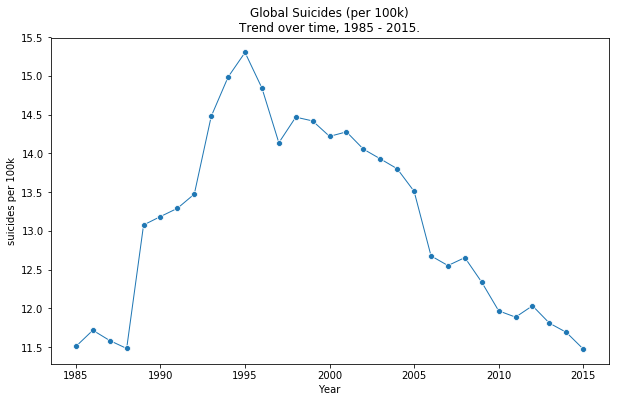

In [9]:
year_result =  pd.DataFrame({"suicides_per_100k": train.groupby(["Year"])['suicides_no'].sum() * 100000 / train.groupby(["Year"])['population'].sum()
                       },index=None)
year_result = year_result.reset_index()
plt.figure(figsize=(10, 6))
# ax = sb.relplot(x='Year', y='suicides_per_100k', kind = 'line', data = year_result, height = 6);
g = sb.lineplot(x='Year', y='suicides_per_100k',data = year_result, marker='o', linewidth='1')
g.set(title='Global Suicides (per 100k)\nTrend over time, 1985 - 2015.', ylabel='suicides per 100k');

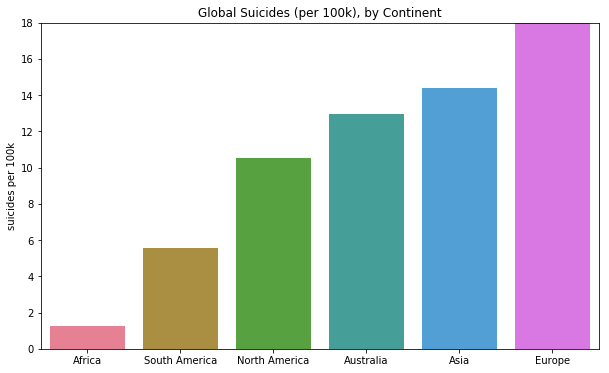

In [10]:
continentresults = pd.DataFrame({"suicides_per_100k": train.groupby(["Continent"])['suicides_no'].sum() / train.groupby(["Continent"])['population'].sum() * 100000
                       },index=None)
continentresults = continentresults.reset_index().sort_values('suicides_per_100k')

plt.figure(figsize=(10, 6))
g = sb.barplot(x='Continent', y= 'suicides_per_100k' ,ci = None, palette="husl"
              ,data = continentresults)

g.set(title='Global Suicides (per 100k), by Continent',xlabel='',ylabel='suicides per 100k')

g.set_ylim(0, 18);

In [11]:
continent_time_results = pd.DataFrame({"suicides_per_100k": train.groupby(["Year","Continent"])['suicides_no'].sum() / train.groupby(["Year","Continent"])['population'].sum() * 100000
                       },index=None)

continent_time_results = continent_time_results.reset_index().sort_values('suicides_per_100k')

Global Suicides (per 100k), by Continent


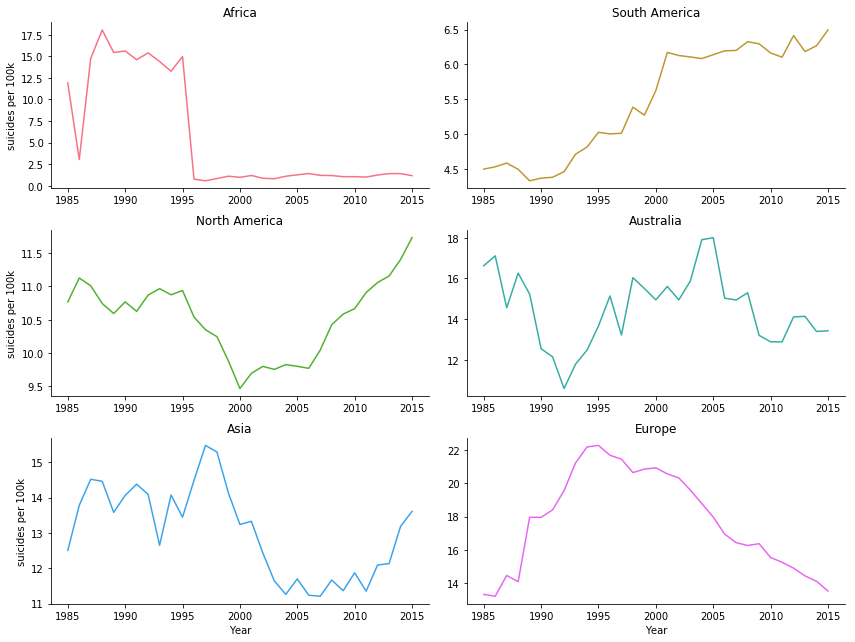

In [12]:
print('Global Suicides (per 100k), by Continent')
g = sb.FacetGrid(continent_time_results, col = 'Continent' , height=3, aspect =2,
                 col_wrap=2,sharex=False, hue ='Continent', sharey=False,  palette="husl")
g.set(xticks = np.arange(1985,2020,5))
g = g.map(sb.lineplot, "Year", "suicides_per_100k");

g.axes[0].set(ylabel ='suicides per 100k')
g.axes[2].set(ylabel ='suicides per 100k')
g.axes[4].set(ylabel ='suicides per 100k')

g.axes[0].set_title('Africa');
g.axes[1].set_title('South America');
g.axes[2].set_title('North America');
g.axes[3].set_title('Australia');
g.axes[4].set_title('Asia');
g.axes[5].set_title('Europe');

Global suicides (per 100k), by Sex



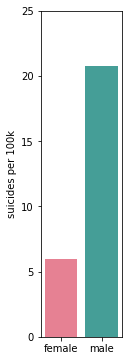

In [13]:
sexresults = pd.DataFrame({"suicides_per_100k": train.groupby(["Sex"])['suicides_no'].sum()* 100000 / train.groupby(["Sex"])['population'].sum() 
                       },index=None)
sexresults = sexresults.reset_index().sort_values('suicides_per_100k')
print('Global suicides (per 100k), by Sex\n')
plt.figure(figsize=(1.45, 6))
g = sb.barplot(x='Sex', y= 'suicides_per_100k' ,ci = None, palette="husl"
              ,data = sexresults)

g.set(xlabel='', ylabel='suicides per 100k')

g.set_ylim(0, 25);

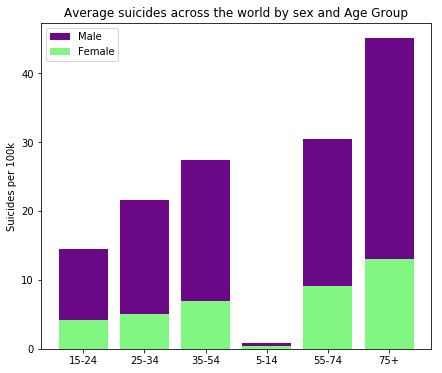

In [14]:
sex_age_df = train[['Sex', 'Age', 'suicides_no','population']].groupby(['Sex', 'Age']).sum().reset_index()
sex_age_df['suicides_per_100k'] = sex_age_df['suicides_no'] * 100000 / sex_age_df['population']

age_groups = sex_age_df['Age'].unique()
male_suicides = sex_age_df[sex_age_df['Sex'] == 'male']['suicides_per_100k']
female_suicides = sex_age_df[sex_age_df['Sex'] == 'female']['suicides_per_100k']
plt.figure(figsize=(7, 6))
plt.bar(age_groups, male_suicides, label='Male', color='#6A0888');
plt.bar(age_groups, female_suicides, label='Female', color='#81F781');

plt.title('Average suicides across the world by sex and Age Group');

plt.ylabel('Suicides per 100k');
plt.legend();

Global suicides (per 100k), by Sex


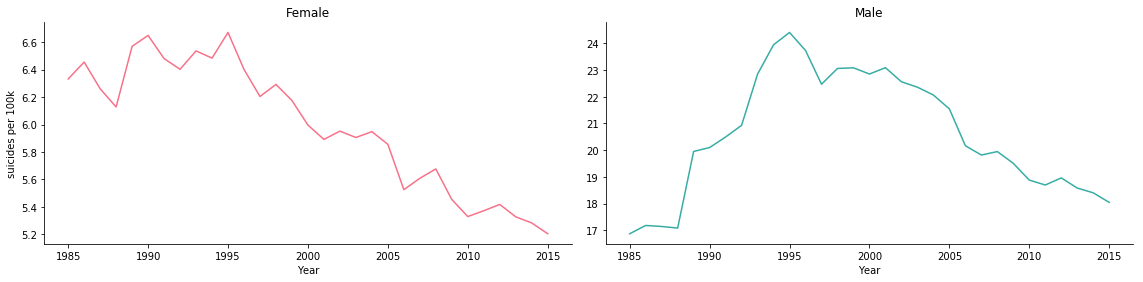

In [15]:
print('Global suicides (per 100k), by Sex')
sex_time_results = pd.DataFrame({"suicides_per_100k": train.groupby(['Year',"Sex"])['suicides_no'].sum() / train.groupby(['Year',"Sex"])['population'].sum() * 100000
                       },index=None)

sex_time_results = sex_time_results.reset_index().sort_values('suicides_per_100k')

g = sb.FacetGrid(sex_time_results, col = 'Sex' , height=4, aspect =2,
                 col_wrap=2,sharex=False, hue ='Sex', sharey=False,  palette="husl");
g = g.map(sb.lineplot, "Year", "suicides_per_100k");
g.axes[0].set(ylabel='suicides per 100k')
# g.set(xticks=x_ticks);
g.axes[0].set_title('Female');
g.axes[1].set_title('Male');

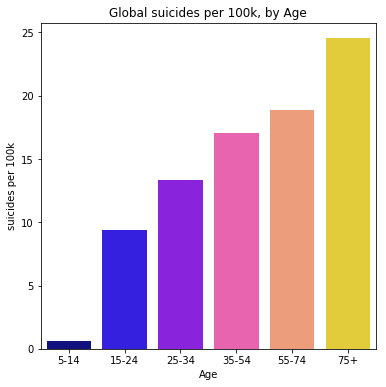

In [16]:
age_results = pd.DataFrame({"suicides_per_100k": train.groupby(['Age'])['suicides_no'].sum() / train.groupby(['Age'])['population'].sum() * 100000
                       },index=None)

age_results = age_results.reset_index().sort_values('suicides_per_100k')

plt.figure(figsize=(6, 6))
g = sb.barplot(x='Age', y= 'suicides_per_100k' ,palette='gnuplot2', ci = None,data = age_results)

g.set(ylabel='suicides per 100k',title='Global suicides per 100k, by Age');

Trends Over Time, by Age


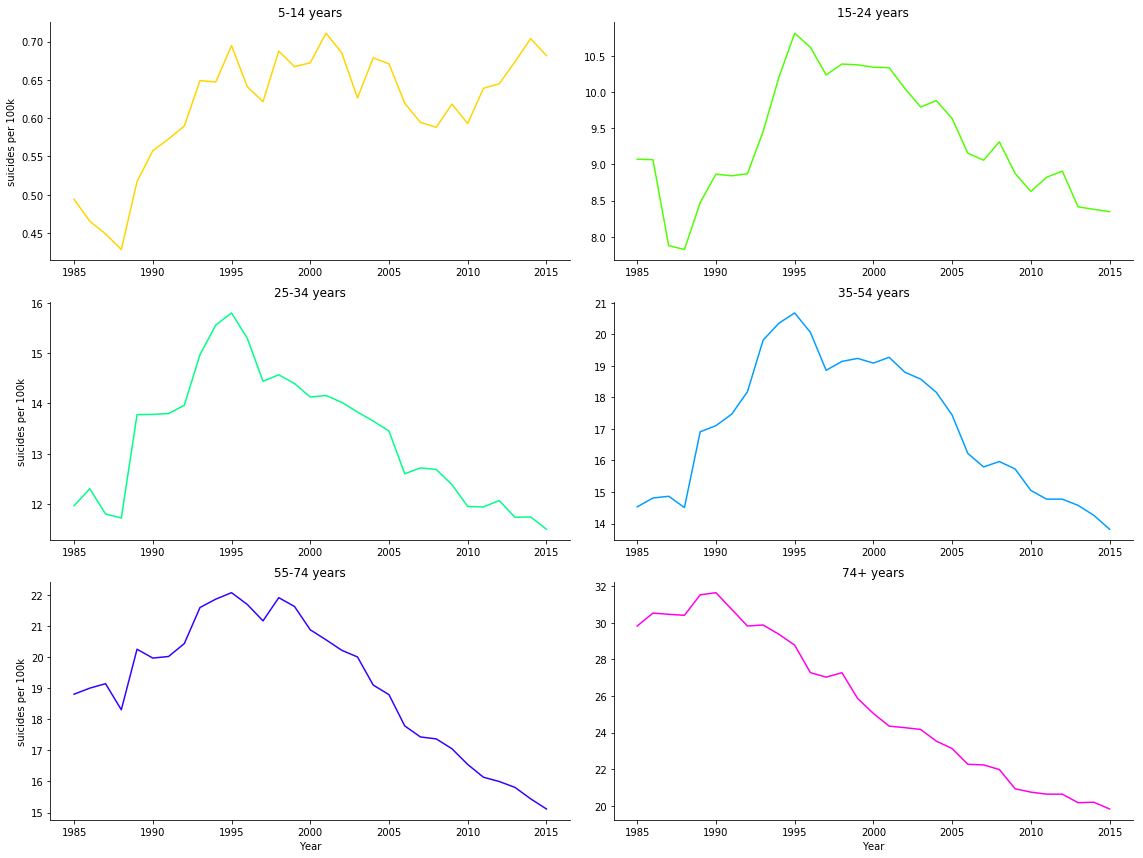

In [17]:
age_time_results = pd.DataFrame({"suicides_per_100k": train.groupby(['Year','Age'])['suicides_no'].sum() / train.groupby(['Year',"Age"])['population'].sum() * 100000
                       },index=None)

age_time_results = age_time_results.reset_index().sort_values('suicides_per_100k')
print('Trends Over Time, by Age')
g = sb.FacetGrid(age_time_results, col = 'Age' , height=4, aspect =2, palette='hsv',
                 col_wrap=2,sharex=False, hue ='Age', sharey=False);
g = g.map(sb.lineplot, "Year", "suicides_per_100k");
# g.set(xticks=x_ticks);
g.axes[0].set(ylabel='suicides per 100k',title='5-14 years');
g.axes[1].set(title='15-24 years');
g.axes[2].set(ylabel='suicides per 100k',title='25-34 years');
g.axes[3].set(title='35-54 years');
g.axes[4].set(ylabel='suicides per 100k',title='55-74 years');
g.axes[5].set(title='74+ years');

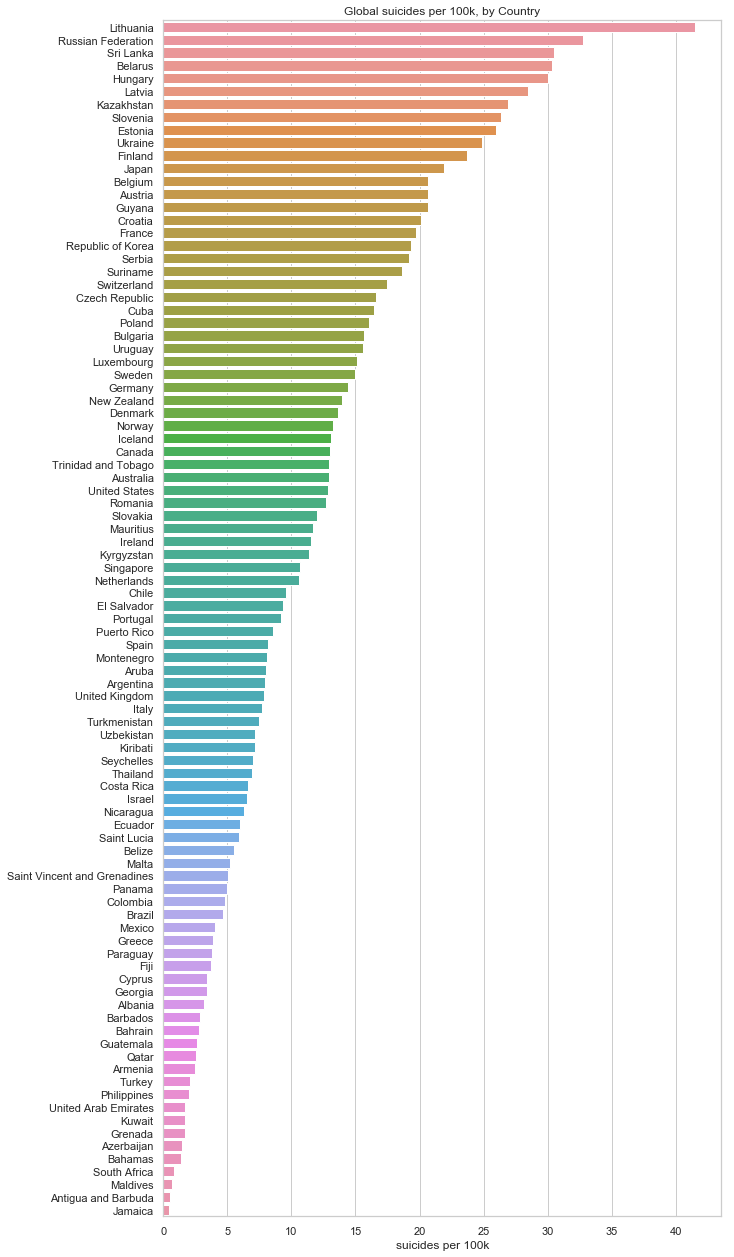

In [18]:
sb.set(style="whitegrid")
country_results = pd.DataFrame({"suicides_per_100k": train.groupby(['Country'])['suicides_no'].sum() / train.groupby(['Country'])['population'].sum() * 100000
                       },index=None)

country_results = country_results.reset_index().sort_values('suicides_per_100k', ascending = False)

plt.figure(figsize=(10,22))
g = sb.barplot(y='Country', x= 'suicides_per_100k' ,ci = None,data = country_results)
g.set(ylabel='', xlabel='suicides per 100k')
g.set_title('Global suicides per 100k, by Country');

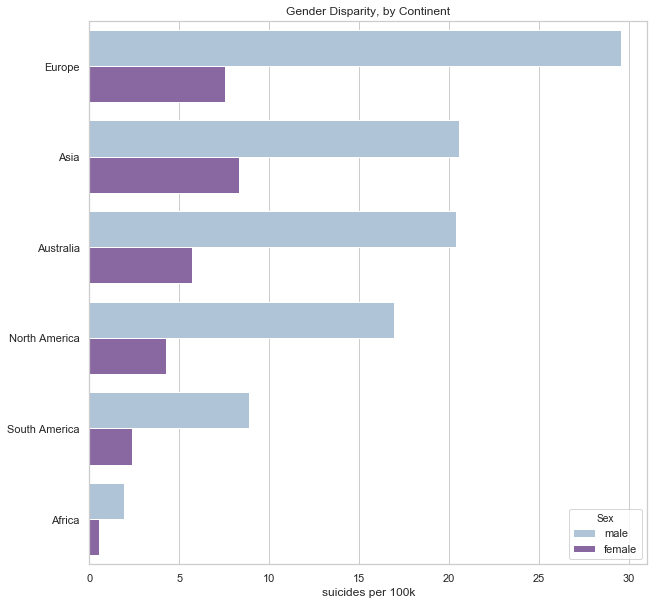

In [19]:
sb.set(style="whitegrid")
gender_continent_results =  pd.DataFrame({"suicides_per_100k": train.groupby(['Sex','Continent'])['suicides_no'].sum() 
                                          / train.groupby(['Sex','Continent'])['population'].sum() * 100000 })
gender_continent_results = gender_continent_results.reset_index().sort_values('suicides_per_100k', ascending = False)

plt.figure(figsize=(10,10))
g = sb.barplot(y='Continent', x= 'suicides_per_100k', hue = 'Sex' ,palette='BuPu',ci = None,
               data = gender_continent_results)

g.set(title='Gender Disparity, by Continent', xlabel='suicides per 100k', ylabel="");

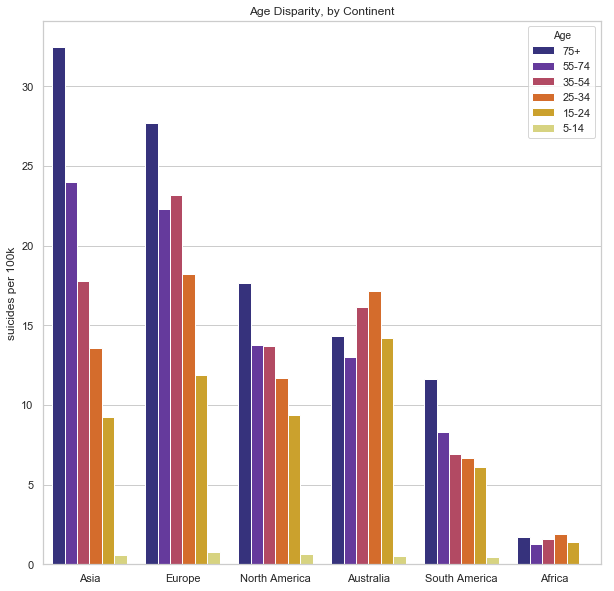

In [20]:
sb.set(style="whitegrid")
age_continent_results = pd.DataFrame({"suicides_per_100k": train.groupby(['Age','Continent'])['suicides_no'].sum() 
                                          / train.groupby(['Age','Continent'])['population'].sum() * 100000 })
age_continent_results = age_continent_results.reset_index().sort_values('suicides_per_100k', ascending = False)

plt.figure(figsize=(10,10))
g = sb.barplot(x='Continent', y= 'suicides_per_100k', hue = 'Age' ,palette="CMRmap", ci = None,
               data = age_continent_results)

g.set(title='Age Disparity, by Continent',xlabel='',ylabel='suicides per 100k');

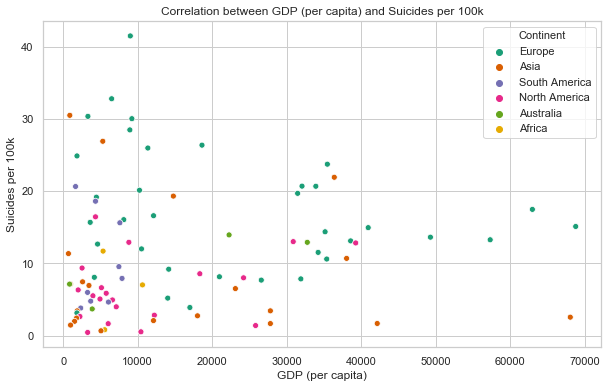

In [21]:
country_mean_gdp = pd.DataFrame({"suicides_per_100k": train.groupby(['Country', 'Continent'])['suicides_no'].sum() 
                                          / train.groupby(['Country','Continent'])['population'].sum() * 100000,
                                "GDPpercapita": train.groupby(['Country','Continent'])['GDPpercapita'].sum()
                                 /train.groupby(['Country','Continent'])['Year'].count()      
                                })

plt.figure(figsize=(10,6))
country_mean_gdp = country_mean_gdp.reset_index().sort_values('suicides_per_100k', ascending = False)
g = sb.scatterplot(y="suicides_per_100k", x="GDPpercapita", hue="Continent", palette = 'Dark2',
         data=country_mean_gdp)
g.set_title('Correlation between GDP (per capita) and Suicides per 100k');
g.set(xlabel= "GDP (per capita)", ylabel = "Suicides per 100k") ;

slope: 8.4e-05
intercept: 9.583
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     2.957
Date:                Thu, 18 Jul 2019   Prob (F-statistic):             0.0891
Time:                        00:41:00   Log-Likelihood:                -298.52
No. Observations:                  87   AIC:                             601.0
Df Residuals:                      85   BIC:                             606.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.583

C:\Users\Vaishali\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


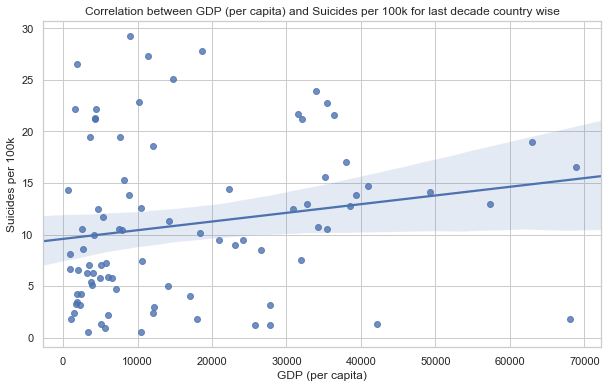

In [22]:
# Filtering the outlier values of greater than 30 

top_gdp = pd.DataFrame({"medianGDP": train.groupby('Country')['GDPpercapita'].mean()
                       ,"suicides_per_100k": train.groupby('Country')['suicides_per_100k'].mean()
                       })
top_gdp = top_gdp.reset_index()
top_gdp = top_gdp[top_gdp['suicides_per_100k']<=30]

plt.figure(figsize=(10,6));
# p=sb.lmplot(x ='medianGDP', y='suicides_per_100k',data = top_gdp, height = 6, aspect = 2);
p = sb.regplot(x='medianGDP',y='suicides_per_100k',data=top_gdp);
p.set_title('Correlation between GDP (per capita) and Suicides per 100k for last decade country wise');
p.set(xlabel= "GDP (per capita)", ylabel = "Suicides per 100k") ;
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),y=p.get_lines()[0].get_ydata());
print('slope: {}'.format(round(slope, 6)))
print('intercept: {}'.format(round(intercept, 3)))
top_gdp[['medianGDP','suicides_per_100k']].corr()
X = np.array(top_gdp['medianGDP'])
y= np.array(top_gdp['suicides_per_100k'])
X = sm.add_constant(X)


m = sm.OLS(y, X)
model = sm.OLS(y, X)
results = m.fit()
print(results.summary())



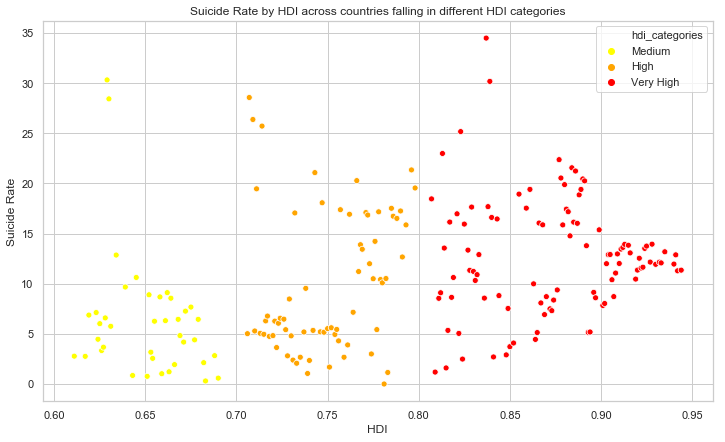

,hdi,suicide_rate
hdi,1.000000,0.344055
suicide_rate,0.344055,1.000000


In [23]:
data_withHDI = train[(train.hdi.notnull()) & (train.Time=='2006 - 2015')]
data_withHDI = data_withHDI.groupby(['hdi'])[['population','suicides_no']].sum().reset_index()
data_withHDI['suicide_rate'] = data_withHDI['suicides_no']*100000/data_withHDI['population']
# HDI Categories
data_withHDI['hdi_categories'] = np.where(data_withHDI['hdi'] >=0.8, "Very High",
                             np.where(data_withHDI['hdi'].between(0.7,0.799), "High",
                             np.where(data_withHDI['hdi'].between(0.555,0.699),"Medium","Low")))

# Plot and Correlation
plt.figure(figsize=(12,7))
ax = sb.scatterplot(x="hdi", y="suicide_rate", hue= 'hdi_categories', palette=['yellow','orange','red'],data=data_withHDI)
ax.set(ylabel='Suicide Rate', xlabel='HDI', title = 'Suicide Rate by HDI across countries falling in different HDI categories')
plt.show()
data_withHDI[['hdi','suicide_rate']].corr()

In [24]:
trend_df = train.groupby(['Country','Year'])['suicides_no','population'].sum().reset_index()
trend_df['suicide_rate'] = trend_df['suicides_no']*100000 / trend_df['population']
# dm = dm[dm['suicides_no'].notnull()]
trends = []
for country in trend_df.Country.unique():
    country_trend = trend_df[trend_df['Country'] == country]
    X = np.array(country_trend['Year']).reshape([-1,1])
    y = np.array(country_trend['suicide_rate']).reshape([-1,1])
    
    model = LinearRegression()
    results = model.fit(X,y).coef_[0][0]
    trends.append([country,results])

    
df_trends = pd.DataFrame(trends,columns=['Country','factor']).sort_values(by='factor')
decrease_trends = list(df_trends['Country'].head(12))
increase_trends = list(df_trends['Country'].tail(12))

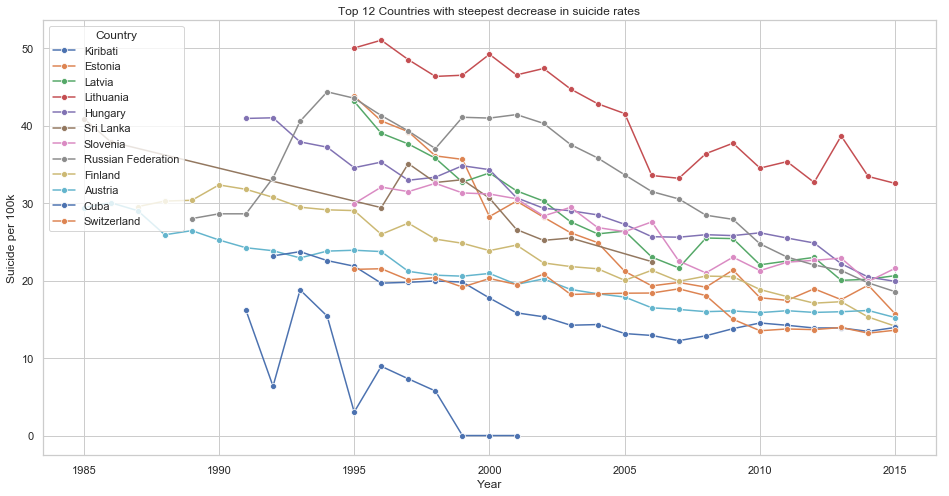

In [25]:
# Countries with decreasing trend
plt.figure(figsize=(16,8))
legends = []
# sb.set_palette(palette='gist_yarg')
for country in decrease_trends:
    country_trend = trend_df[trend_df['Country'] == country]
    g = sb.lineplot(x="Year", y="suicide_rate", data=country_trend , marker='o')
    legends.append(country)

plt.legend(title='Country', loc='upper left', labels=legends)
g.set(ylabel='Suicide per 100k', xlabel='Year', title = 'Top 12 Countries with steepest decrease in suicide rates')
plt.show()

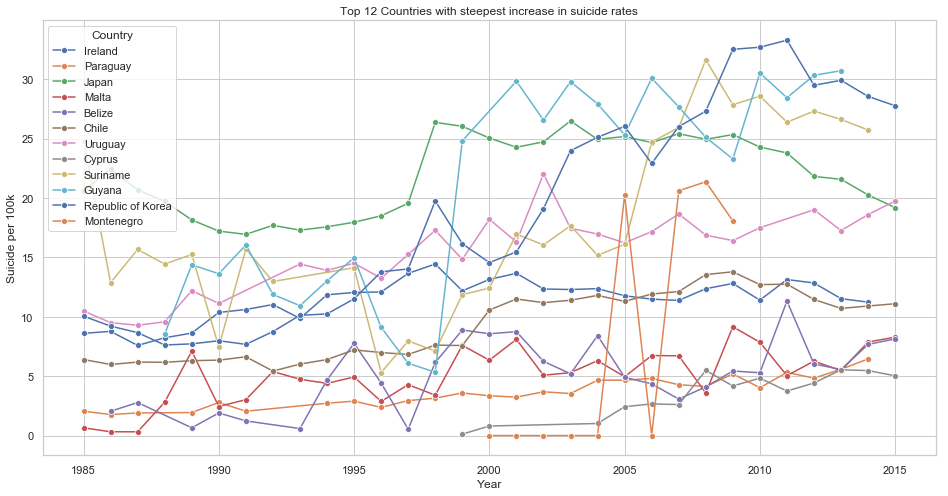

In [26]:
# Countries with increasing trend
plt.figure(figsize=(16,8))
legend = []

for country in increase_trends:
    country_trend = trend_df[trend_df['Country'] == country]
    g = sb.lineplot(x="Year", y="suicide_rate",data=country_trend,marker='o')
    legend.append(country)

plt.legend(title='Country', loc='upper left', labels=legend)
g.set(ylabel='Suicide per 100k', xlabel='Year', title = 'Top 12 Countries with steepest increase in suicide rates')
plt.show()

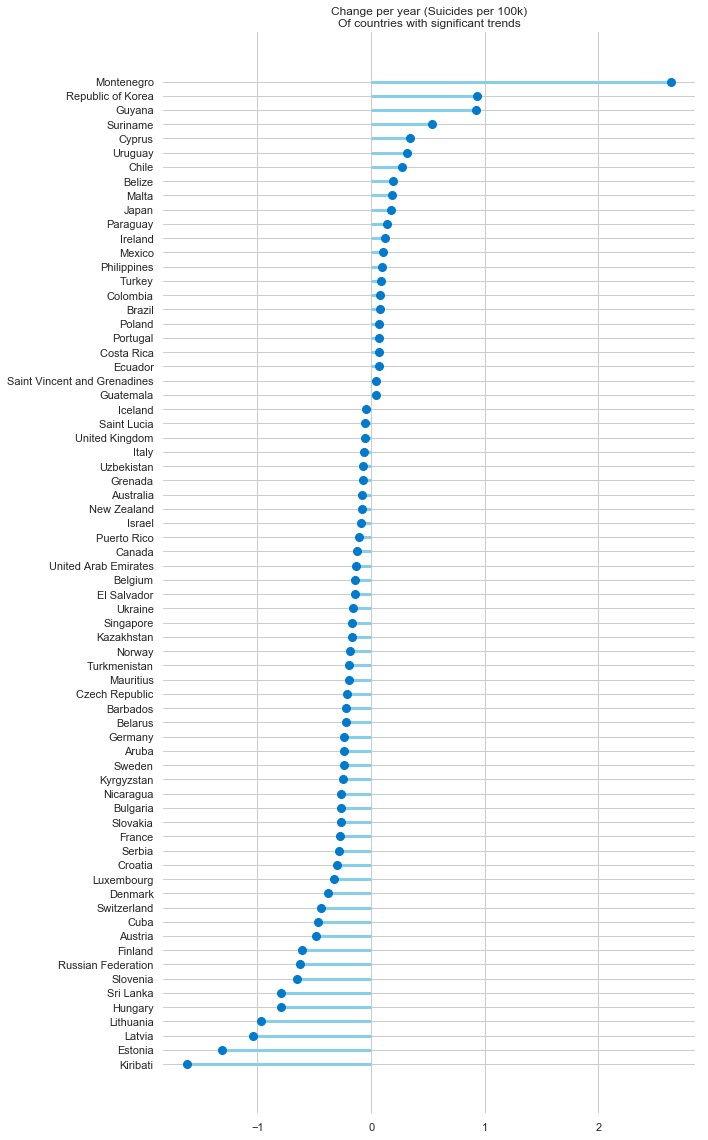

In [27]:
df_trends = df_trends[~df_trends.factor.between(-0.04, 0.04)]
countries = df_trends.Country.unique()

ax = plt.figure(figsize=(10,16));

ax1 = plt.hlines(y=countries, xmin=0, xmax=df_trends['factor'], color='skyblue', linewidth=3)
ax2 = plt.plot(df_trends['factor'], countries, "o", markersize=8, color='#007acc')

plt.title('Change per year (Suicides per 100k)\nOf countries with significant trends')

plt.tight_layout()
plt.yticks(countries)

plt.box(False)

In [28]:
country_wide = train[['suicides_per_100k','Country','suicides_no','population']]
country_wide = country_wide[country_wide.Country.isin(df_trends.Country)]
country_wide = pd.DataFrame({'suicides_no': country_wide.groupby(['Country'])['suicides_no'].sum()})

country_wide = pd.concat([country_wide,country_wide], axis = 0)
country_wide = country_wide.sort_values('Country')
country_wide = country_wide.reset_index()
sex_country_wide = train[['Sex','suicides_per_100k','Country','suicides_no','population']]
sex_country_wide = sex_country_wide[sex_country_wide.Country.isin(df_trends.Country)]

sex_country_wide = pd.DataFrame({'suicides_no': sex_country_wide.groupby(['Country','Sex'])['suicides_no'].sum()})
sex_country_wide = sex_country_wide.sort_values('Country')
sex_country_wide = sex_country_wide.reset_index()

sex_country_wide['prop'] = sex_country_wide['suicides_no'] * 100/(country_wide['suicides_no'])

sex_country_wide.loc[sex_country_wide.Sex=='male','prop'] = 100

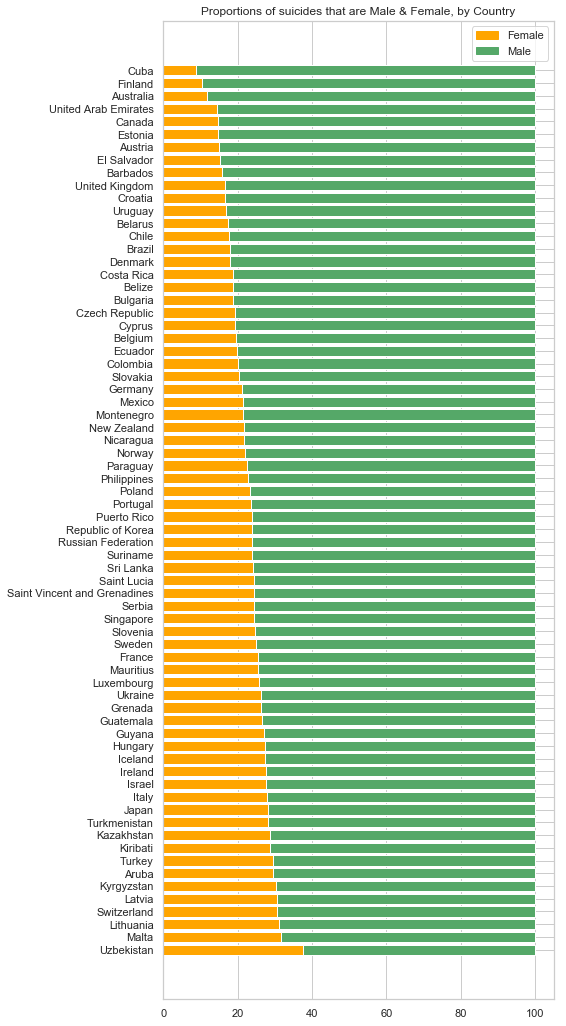

In [29]:
orange = mpatches.Patch(color='orange', label='Female')
green = mpatches.Patch(color='g', label='Male')

sex_country_wide = sex_country_wide.sort_values('prop', ascending=False)
y_pos = sex_country_wide.Country.unique()
bottomdata = sex_country_wide[sex_country_wide.Sex=='male']['prop']     #[100] * len(greenBars)                   #greenBars
topdata = sex_country_wide[sex_country_wide.Sex=='female']['prop']

fig = plt.figure(figsize=(7,18));
ax = fig.add_subplot(111);
ax.title.set_text('Proportions of suicides that are Male & Female, by Country')
ax.barh(y_pos, bottomdata,color='g',align='center');
ax.barh(y_pos, topdata,color='orange',align='center');
ax.legend(handles=[orange,green]);

5% Most At-Risk Instances in History


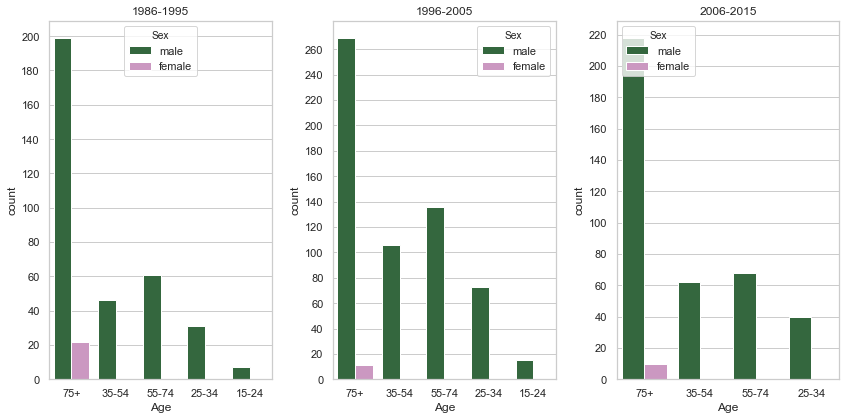

In [30]:
top  = round((train.shape[0]*5)/100)
demographic_most = train[train.Year!=1985][['Age','Sex','suicides_per_100k','Year','Time','suicides_no','population']]
demographic_most = demographic_most.sort_values('suicides_per_100k',ascending=False).head(top)
# demographic_most['Time'] = demographic_most['Year'].apply(lambda x: "1986 - 1995" if x <= 1995 
#                                                                else ('1996 - 2005' if x <= 2005 else "2006 - 2015"))
# demographic_most = pd.DataFrame({"suicides_per_100k": demographic_most.groupby(['Time', 'Age'])['suicides_no'].sum() 
#                                           / demographic_most.groupby(['Time', 'Age'])['population'].sum() * 100000,
                                     
#                                 })
demographic_most = demographic_most.reset_index()
df_1986_1995 = demographic_most[demographic_most.Time == '1986 - 1995']
df_1996_2005 = demographic_most[demographic_most.Time == '1996 - 2005']
df_2006_2015 = demographic_most[demographic_most.Time == '2006 - 2015']

# plt.figure(figsize=(10,6))
print('5% Most At-Risk Instances in History')
fig, axs = plt.subplots(nrows = 1,ncols = 3, figsize=(12,6))


axs[0].set(yticks=list(np.arange(0,280,20)))
axs[1].set(yticks=list(np.arange(0,280,20)))
axs[2].set(yticks=list(np.arange(0,280,20)))

sb.countplot(x='Age', hue='Sex',palette="cubehelix",data = df_1986_1995, ax=axs[0]).set_title('1986-1995');
sb.countplot(x='Age', hue='Sex',palette="cubehelix",data = df_1996_2005, ax=axs[1]).set_title('1996-2005');
sb.countplot(x='Age',hue='Sex',palette="cubehelix",data = df_2006_2015, ax=axs[2]).set_title('2006-2015');
fig.tight_layout();

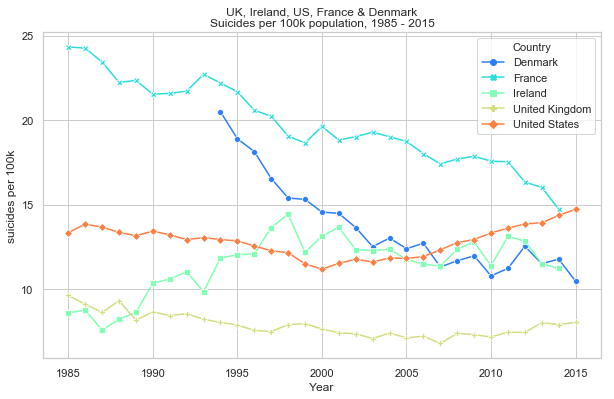

In [31]:
overtime_df = train[((train.Country=='Denmark') | (train.Country=='Ireland') | (train.Country=='United Kingdom') | (train.Country=='France') | (train.Country=='United States'))][['Year','Country','Age','Sex','suicides_no','population']]
overtime_df = pd.DataFrame({"suicides_per_100k": overtime_df.groupby(['Country', 'Year'])['suicides_no'].sum() 
                                          / overtime_df.groupby(['Country','Year'])['population'].sum() * 100000,
                                     
                                })

overtime_df = overtime_df.reset_index()
plt.figure(figsize=(10,6))
sb.lineplot(x="Year", y="suicides_per_100k", hue="Country", style='Country', 
            palette='rainbow',markers=True, dashes=False, data=overtime_df, ci=None).set(yticks = [10,15,20,25]
    ,title="UK, Ireland, US, France & Denmark\nSuicides per 100k population, 1985 - 2015", ylabel='suicides per 100k');

UK, Ireland, US, France & Denmark, 
Suicides per 100k population, 1985 - 2015


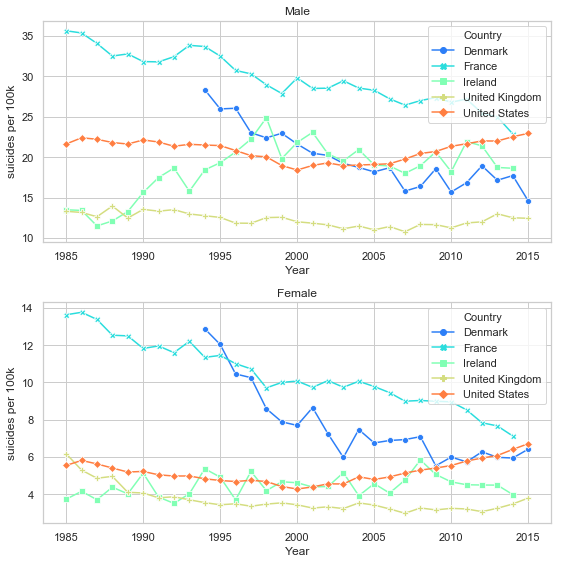

In [32]:
sex_overtime_df = train[((train.Country=='Denmark') | (train.Country=='Ireland') | (train.Country=='United Kingdom') | (train.Country=='France') | (train.Country=='United States'))][['Year','Country','Age','Sex','suicides_no','population']]
sex_overtime_df = pd.DataFrame({"suicides_per_100k": sex_overtime_df.groupby(['Country', 'Sex','Year'])['suicides_no'].sum() 
                                          / sex_overtime_df.groupby(['Country', 'Sex','Year'])['population'].sum() * 100000,
                                     
                                })
sex_overtime_df = sex_overtime_df.reset_index()
male_overtime_df = sex_overtime_df[sex_overtime_df.Sex=='male']
female_overtime_df = sex_overtime_df[sex_overtime_df.Sex=='female']
# g = sb.FacetGrid(sex_overtime_df, col='Sex', col_wrap = 1, height= 4, aspect =1)
# g.map(sb.lineplot, x="Year", y="suicides_per_100k", hue="Country", style='Country', palette='rainbow',
# markers=True, dashes=False, data=df_25_34, ci=None)


fig, axs = plt.subplots(2,figsize=(8,8))


# axs[0].set(yticks=list(np.arange(0,14,2.5)))
# axs[1].set(yticks=list(np.arange(0,40,10)))
print('UK, Ireland, US, France & Denmark, \nSuicides per 100k population, 1985 - 2015')
sb.lineplot(x="Year", y="suicides_per_100k", hue="Country", style='Country', palette='rainbow',
markers=True, dashes=False, data=male_overtime_df, ci=None,ax=axs[0]).set(title='Male',ylabel='suicides per 100k');
sb.lineplot(x="Year", y="suicides_per_100k", hue="Country", style='Country', palette='rainbow',
markers=True, dashes=False, data=female_overtime_df, ci=None,ax=axs[1]).set(title='Female',ylabel='suicides per 100k');
fig.tight_layout();


Proportion of suicides that were Male & Female
 2010 - 2015 only for 5 countries


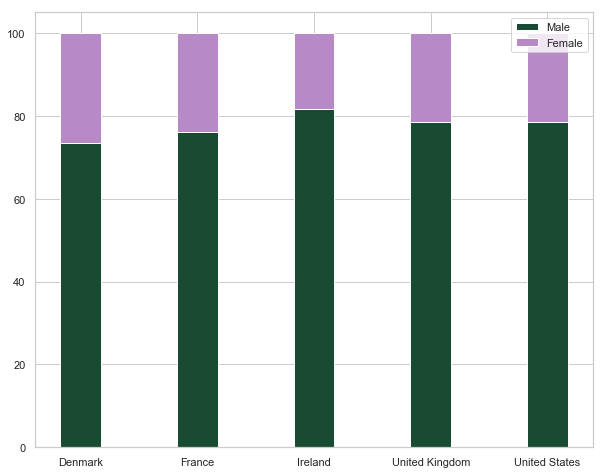

In [33]:
recent_df = train[(train.Year>=2010) & ((train.Country=='Denmark') | (train.Country=='Ireland') | (train.Country=='United Kingdom') | (train.Country=='France') | (train.Country=='United States'))][['Country','Sex','suicides_no','population']]
recent_df = pd.DataFrame({"suicides_per_100k": recent_df.groupby(['Country', 'Sex'])['suicides_no'].sum() 
                                          / recent_df.groupby(['Country', 'Sex'])['population'].sum() * 100000,
                                     
                                })
recent_df = recent_df.reset_index()
print('Proportion of suicides that were Male & Female\n 2010 - 2015 only for 5 countries')

r = recent_df.Country.unique()
greenBars = recent_df[recent_df.Sex=='male']['suicides_per_100k']   #male
orangeBars =recent_df[recent_df.Sex=='female']['suicides_per_100k']   #female 
plt.figure(figsize=(10,8))
df = pd.DataFrame({ 'greenBars': list(greenBars),
                    'orangeBars': list(orangeBars)
})
barWidth = 0.35
totals = [i + j for i, j in zip(df['greenBars'], df['orangeBars'])]
greenBars = [i / j * 100 for i,j in zip(df['greenBars'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df['orangeBars'], totals)]

p1=plt.bar(r, greenBars, color='#194B32', edgecolor='white', width=barWidth);   #b5ffb9
# Create orange Bars
p2 = plt.bar(r, orangeBars, bottom=greenBars, color='#B789C7', edgecolor='white', width=barWidth);  #f9bc86

plt.legend((p1[0], p2[0]), ('Male', 'Female'));

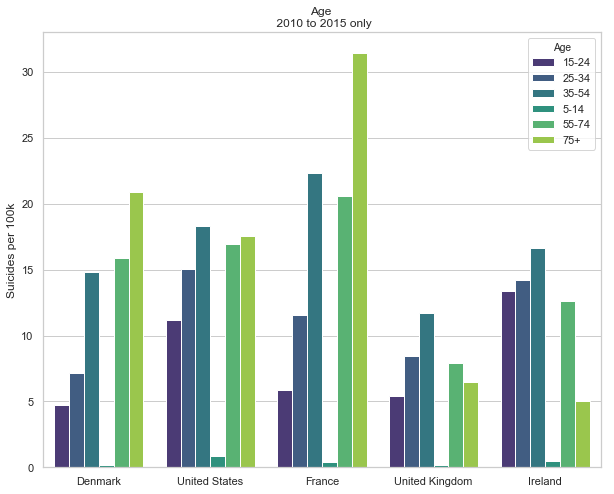

In [34]:
recent_age_df = train[(train.Year>=2010) & ((train.Country=='Denmark') | (train.Country=='Ireland') | (train.Country=='United Kingdom') | (train.Country=='France') | (train.Country=='United States'))][['Country','Age','Sex','suicides_no','population']]
recent_age_df = pd.DataFrame({"suicides_per_100k": recent_age_df.groupby(['Country','Age'])['suicides_no'].sum() 
                                          / recent_age_df.groupby(['Country','Age'])['population'].sum() * 100000,
                                     
                                })
recent_age_df = recent_age_df.reset_index().sort_values('Age')

plt.figure(figsize=(10, 8));
g=sb.barplot(x = 'Country', y='suicides_per_100k',hue='Age',data = recent_age_df, palette='viridis');

g.set(title='Age \n 2010 to 2015 only', ylabel = "Suicides per 100k", xlabel='');

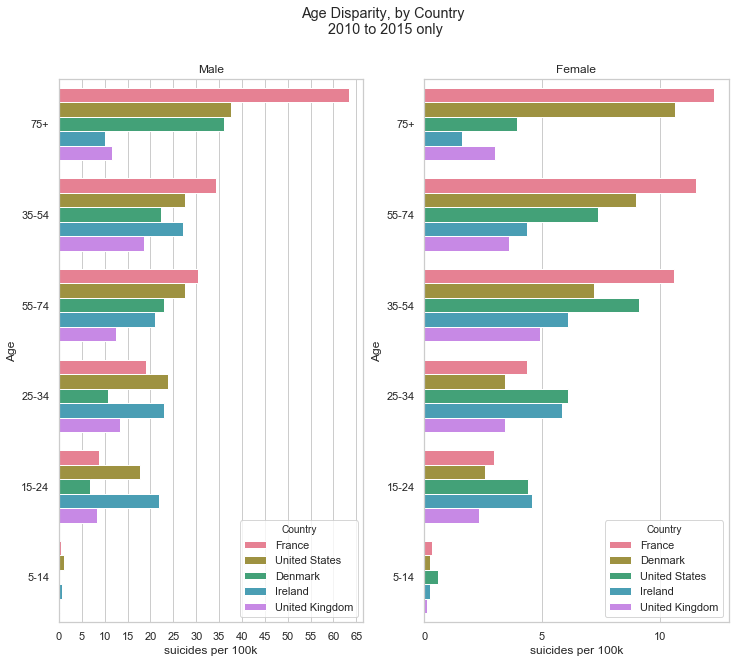

In [35]:
recent_sex_age_df = train[(train.Year>=2010) & ((train.Country=='Denmark') | (train.Country=='Ireland') | (train.Country=='United Kingdom') | (train.Country=='France') | (train.Country=='United States'))][['Country','Age','Sex','suicides_no','population']]
recent_sex_age_df = pd.DataFrame({"suicides_per_100k": recent_sex_age_df.groupby(['Country','Age','Sex'])['suicides_no'].sum() 
                                          / recent_sex_age_df.groupby(['Country','Age','Sex'])['population'].sum() * 100000,
                                     
                                })
recent_sex_age_df = recent_sex_age_df.reset_index().sort_values('suicides_per_100k', ascending=False)
recent_male_age_df = recent_sex_age_df[recent_sex_age_df.Sex=='male']
recent_female_age_df = recent_sex_age_df[recent_sex_age_df.Sex=='female']

fig, axs = plt.subplots(nrows=1,ncols = 2,figsize=(12,10), sharex=False)
fig.suptitle('Age Disparity, by Country\n 2010 to 2015 only')
axs[0].set(xticks=list(np.arange(0,80,5)))
axs[1].set(xticks=list(np.arange(0,80,5)))

axs[0].set_title('Male')
axs[1].set_title('Female')


# p1.legend(loc='center right', bbox_to_anchor=(1.25, 1.2), ncol=6);
p1 = sb.barplot(y='Age',x='suicides_per_100k',hue='Country', palette="husl",data = recent_male_age_df, ax=axs[0], ci=None).set(xlabel='suicides per 100k');
p2 = sb.barplot(y='Age',x='suicides_per_100k',hue='Country', palette="husl",data = recent_female_age_df, ax=axs[1], ci=None).set(xlabel='suicides per 100k');

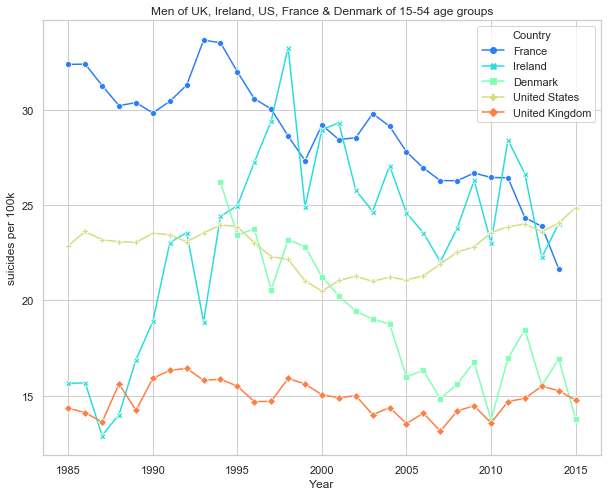

In [36]:
male_age_df = train[(train.Sex>='male') & ((train.Age=='15-24') | (train.Age=='25-34') | (train.Age=='35-54'))][['Country','Year','Age','suicides_no','population']]
male_age_df = male_age_df[(male_age_df.Country=='Denmark') | 
                          (male_age_df.Country=='Ireland') | 
                          (male_age_df.Country=='United Kingdom') | 
                          (male_age_df.Country=='France') | 
                          (male_age_df.Country=='United States')]
male_age_df = pd.DataFrame({"suicides_per_100k": male_age_df.groupby(['Country','Year'])['suicides_no'].sum() 
                                          / male_age_df.groupby(['Country','Year'])['population'].sum() * 100000,
                                     
                                })
male_age_df = male_age_df.reset_index().sort_values('suicides_per_100k', ascending=False)

plt.figure(figsize=(10, 8))
g = sb.lineplot(x="Year", y="suicides_per_100k", 
                   hue="Country", style='Country', palette='rainbow',
                   markers=True, dashes=False, data=male_age_df, ci=None);
g.set(title='Men of UK, Ireland, US, France & Denmark of 15-54 age groups',ylabel='suicides per 100k');

UK, Ireland, US, France & Denmark
 Suicides per 100k for 3 age groups


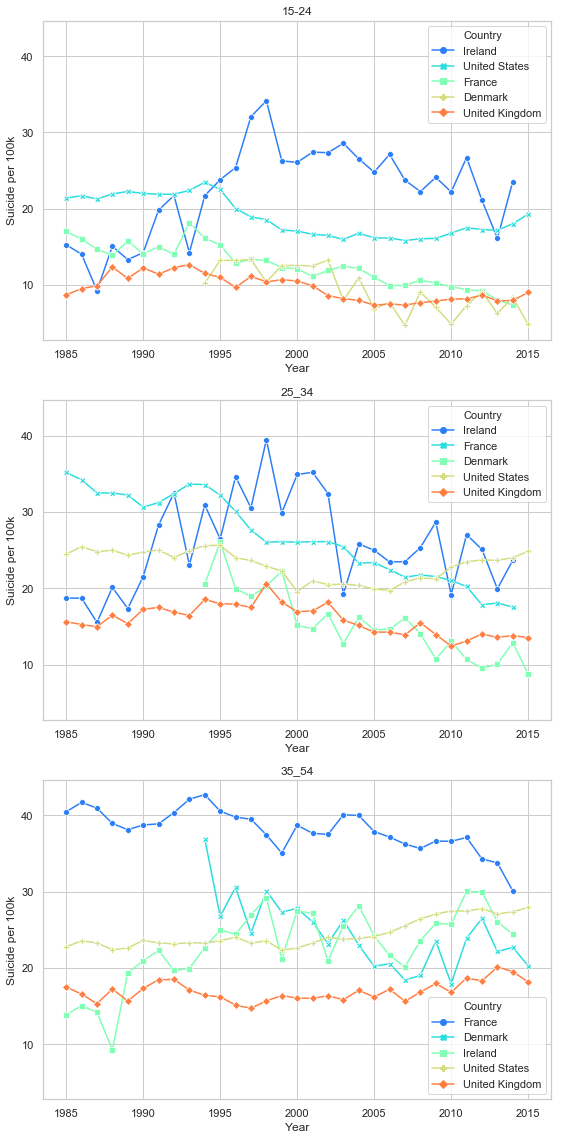

In [37]:
male_df = train[(train.Sex>='male') & ((train.Age=='15-24') | (train.Age=='25-34') | (train.Age=='35-54'))][['Country','Year','Age','suicides_no','population']]
male_df = male_df[(male_df.Country=='Denmark') | 
                          (male_df.Country=='Ireland') | 
                          (male_df.Country=='United Kingdom') | 
                          (male_df.Country=='France') | 
                          (male_df.Country=='United States')]
male_df = pd.DataFrame({"suicides_per_100k": male_df.groupby(['Country','Year','Age'])['suicides_no'].sum() 
                                          / male_df.groupby(['Country','Year','Age'])['population'].sum() * 100000,
                                     
                                })
male_df = male_df.reset_index().sort_values('suicides_per_100k', ascending=False)

df_15_24 = male_df[male_df.Age=='15-24']
df_25_34 = male_df[male_df.Age=='25-34']
df_35_54 = male_df[male_df.Age=='35-54']



# df_15_24['suicides_per_100k'] = df_15_24.groupby('Year')
print('UK, Ireland, US, France & Denmark\n Suicides per 100k for 3 age groups')
fig, axs = plt.subplots(3,figsize=(8,16), sharey=True)

axs[0].set(yticks=list(np.arange(0,60,10)))
axs[1].set(yticks=list(np.arange(0,60,10)))
axs[2].set(yticks=list(np.arange(0,60,10)))

sb.lineplot(x="Year", y="suicides_per_100k", hue="Country", style='Country', palette='rainbow',
markers=True, dashes=False, data=df_15_24, ci=None,ax=axs[0]).set(title='15-24', ylabel='Suicide per 100k');
sb.lineplot(x="Year", y="suicides_per_100k", hue="Country", style='Country', palette='rainbow',
markers=True, dashes=False, data=df_25_34, ci=None,ax=axs[1]).set(title='25_34', ylabel='Suicide per 100k');
sb.lineplot(x="Year", y="suicides_per_100k", hue="Country", style='Country', palette='rainbow',
markers=True, dashes=False, data=df_35_54, ci=None,ax=axs[2]).set(title='35_54', ylabel='Suicide per 100k');
fig.tight_layout();

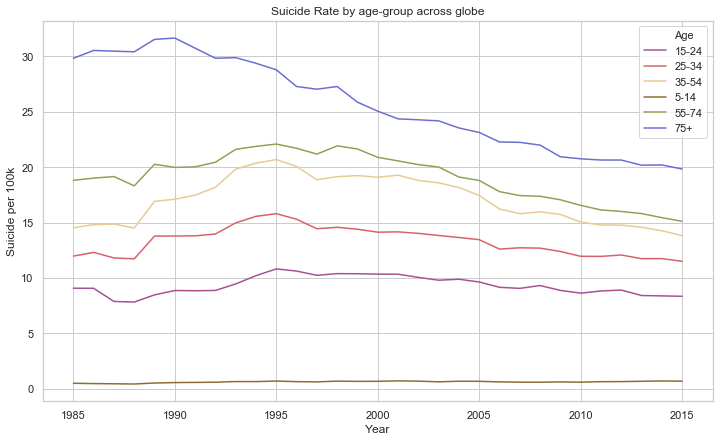

In [38]:
plt.figure(figsize=(12,7))
df_year_age = train.groupby(['Year','Age'])[['population','suicides_no']].sum().reset_index()
df_year_age['suicide_rate'] = df_year_age['suicides_no']*100000/df_year_age['population']
g = sb.lineplot(x="Year", y="suicide_rate",hue = 'Age',data=df_year_age,  palette='tab20b_r',legend="full");
g.set(ylabel='Suicide per 100k', xlabel='Year', title = 'Suicide Rate by age-group across globe');

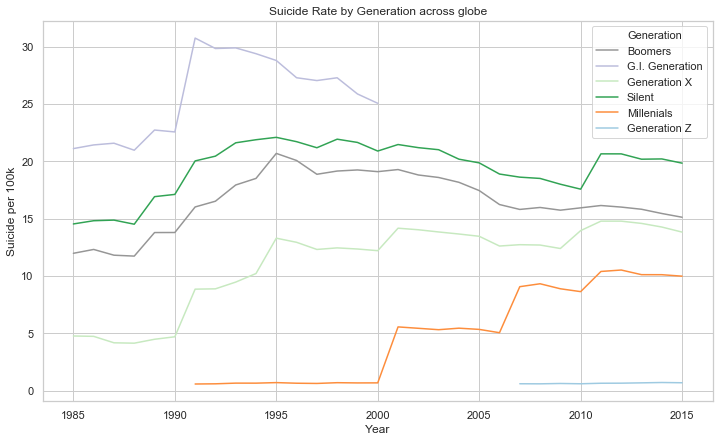

In [39]:
plt.figure(figsize=(12,7))
df_gen = train.groupby(['Year','Generation'])[['population','suicides_no']].sum().reset_index()
df_gen['suicide_rate'] = df_gen['suicides_no']*100000/df_gen['population']
ax = sb.lineplot(x="Year", y="suicide_rate",hue = 'Generation',palette='tab20c_r',data=df_gen,  legend="full");
ax.set(ylabel='Suicide per 100k', xlabel='Year', title = 'Suicide Rate by Generation across globe');

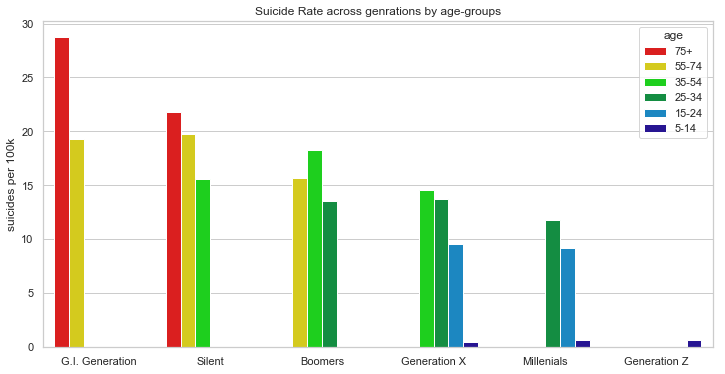

In [40]:
age_gen =  train.groupby(['Generation','Age'])[['population','suicides_no']].sum().reset_index()
age_gen['suicides_per_100k'] = age_gen.suicides_no*100000/age_gen.population
age_gen = age_gen.sort_values('suicides_per_100k', ascending=False)
plt.figure(figsize=(12,6))

g = sb.barplot(x = 'Generation',y = 'suicides_per_100k', palette = 'nipy_spectral_r',hue='Age',data=age_gen);
g.legend(loc =1, title = 'age');
g.set(ylabel='suicides per 100k', xlabel='', title = 'Suicide Rate across genrations by age-groups');

In [41]:
# As a country gets richer, does it’s suicide rate decrease?
# I calculated the pearson correlations between ‘year’ and ‘GDP per capita’ within each country, then summarized the results:
# The mean correlation was 0.878, indicating a very strong positive linear relationship.
# This basically means that looking within a country and asking “does an increase in weath (per person) have an effect suicide rate” is pretty similar to asking “does a countries suicide rate increase as time progresses”.
# it depends on the country! Some countries are increasing with time, most are decreasing


def average(x):
    assert len(x) > 0
    return float(sum(x)) / len(x)

def pearson_def(x,y):
    
    x=list(x)
    y=list(y)
    
    
    n = len(x)
    
    avg_x = average(x)
    avg_y = average(y)
    diffprod = 0
    xdiff2 = 0
    ydiff2 = 0
    for idx in range(n):
        xdiff = x[idx] - avg_x
        ydiff = y[idx] - avg_y
        diffprod += xdiff * ydiff
        xdiff2 += xdiff * xdiff
        ydiff2 += ydiff * ydiff

    return diffprod / math.sqrt(xdiff2 * ydiff2)

mean_y = train.groupby('Country').apply(lambda x: pearson_def(x['Year'],x['GDPpercapita']))
print(mean_y.mean())

0.8780946558412762


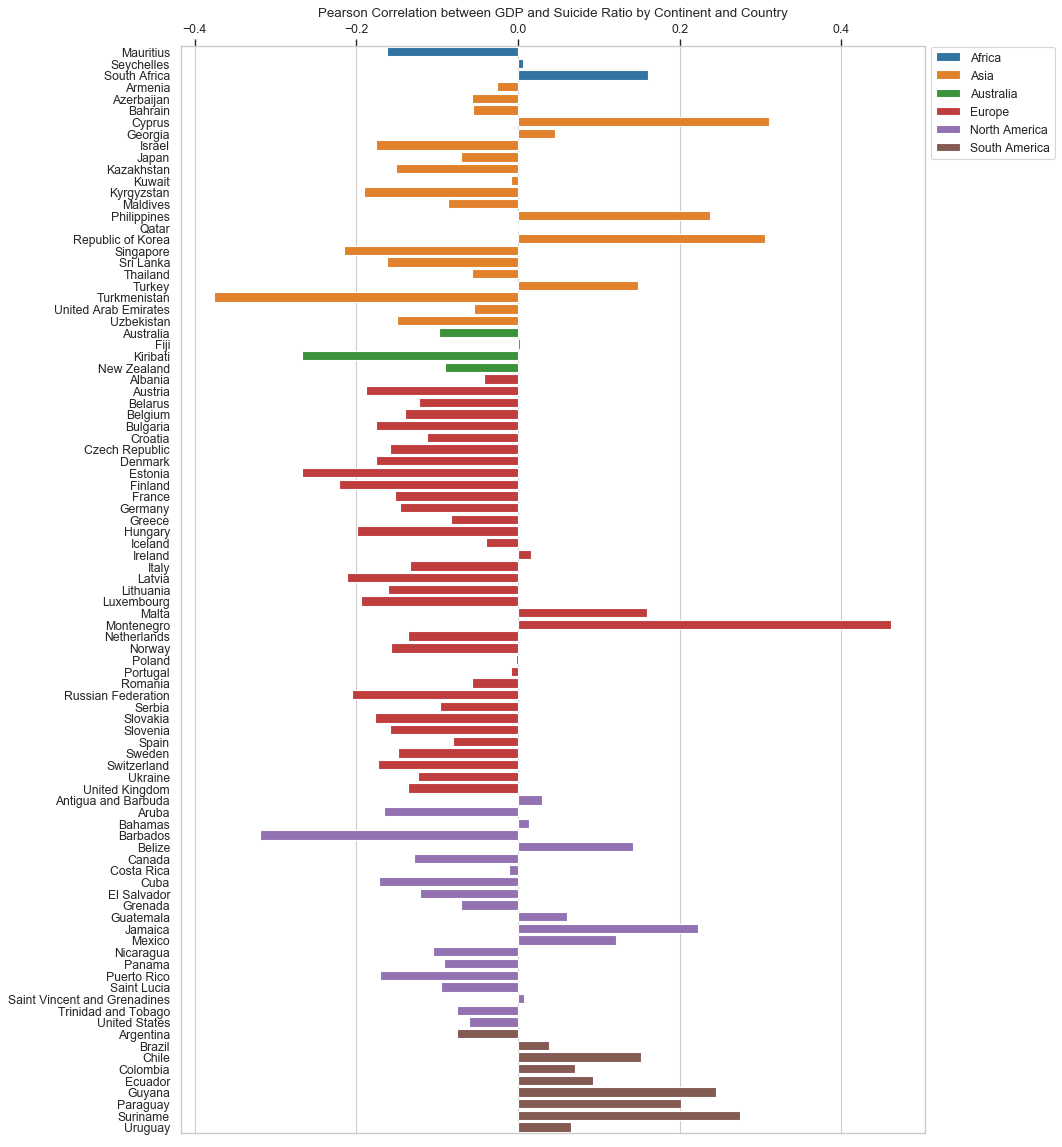

In [42]:
#GDP by Country and suicide rate
ctr_list = train['Country'].unique()
Continent = train.groupby(['Country','Continent'])['population'].sum().reset_index()
Continent.drop(columns=['population','Country'], axis = 1, inplace=True)
Continents = Continent['Continent'].tolist()
correlations = []

for ctr in ctr_list:
    temp_data = train.query("Country == @ctr")
    
    correlations.append(temp_data[['GDPpercapita', 'suicides_per_100k']].corr().iloc[0, 1])
#     correlations.append(pearson_def(temp_data['GDPpercapita'], temp_data['suicides_per_100k']))
    
correlations = np.array(correlations)

country_corr = pd.DataFrame({'Country':ctr_list, 'GDP_Suicide_Corr':correlations, 'Continent': Continents})

country_corr = country_corr.sort_values(['Continent','Country'])
fig, ax = plt.subplots(figsize=(12,18), dpi=80);
sb.barplot(data=country_corr, y='Country', x='GDP_Suicide_Corr',
            hue='Continent', dodge=False, palette='tab10',
            ).set(ylabel='');

ax.set_title('Pearson Correlation between GDP and Suicide Ratio by Continent and Country')
ax.xaxis.tick_top()
ax.xaxis.label.set_visible(False)
ax.legend(bbox_to_anchor=[1.0, 0.89]);

C:\Users\Vaishali\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


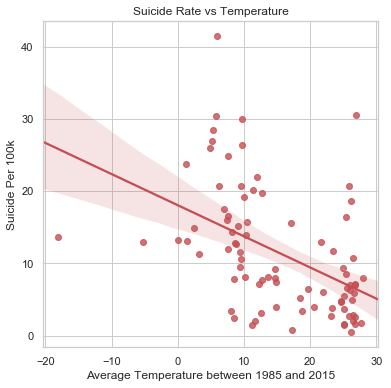

In [43]:
# suicide and Temperature
country_data = train.groupby('Country')['suicides_no','population'].sum().reset_index()
country_data['suicides_no'] = country_data['suicides_no'] * 100000 / country_data['population']
country_year_temperature_data = pd.read_csv('./cleaned_temperature_data.csv')

country_temperature_data = country_year_temperature_data.groupby('Country').mean().reset_index()
country_temperature_data.drop(country_temperature_data.columns[country_temperature_data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
temperature_data = country_data.merge(country_temperature_data,
                                      left_index=True,
                                      on='Country',
                                      how='left')

# new = pd.concat([country_data,country_temperature_data], join = 'left', axis = 1)
plt.figure(figsize=(6,6));
# fig, ax = standard_plot('Suicide Per 100k versus Temperature', 'Average Temperature', 'Suicide Per 100k')
# fig.set_size_inches(8,8)
g = sb.regplot(data = temperature_data, x='AverageTemperature',
              y='suicides_no', color='C3')
g.set(xlabel='Average Temperature between 1985 and 2015', ylabel='Suicide Per 100k', title = 'Suicide Rate vs Temperature');

In [44]:
temperature_data[['AverageTemperature', 'suicides_no']].corr().iloc[0, 1]

-0.4741188338498785

In [45]:

us_df = train[(train['Country']=='United States') & train['Year'].between(2005,2009)][['Country','Year','GDPpercapita','suicides_no','population']]
# us_df = us_df.groupby('Country').agg({'Year':'count', 
#                          'GDPpercapita':'mean', 
#                          'suicides_no':'sum',
#                            'population': 'sum'})
# us_df['suicides_no'] = us_df['suicides_no'] * 100000 / us_df['population'] 

In [46]:
recession_df = train[train['Year'].between(2005,2008)][['Country','Year','GDPpercapita','suicides_no','population']]

recession_df = recession_df.groupby(['Country','Year'])['suicides_no','population'].sum().reset_index()
recession_df['suicide_rate'] = recession_df['suicides_no']*100000 / recession_df['population']

recession_trends = []
for country in recession_df.Country.unique():
    country_trend = recession_df[recession_df['Country'] == country]
    
    X = np.array(recession_df['Year']).reshape([-1,1])
    y = np.array(recession_df['suicide_rate']).reshape([-1,1])
    
    model = LinearRegression()
    diff = model.fit(X,y).coef_[0][0]
    
    trends.append([country,diff])

    
df_recession_trends = pd.DataFrame(trends,columns=['Country','factor']).sort_values(by='factor')
df_recession_trends = df_recession_trends[df_recession_trends.factor>0.03]

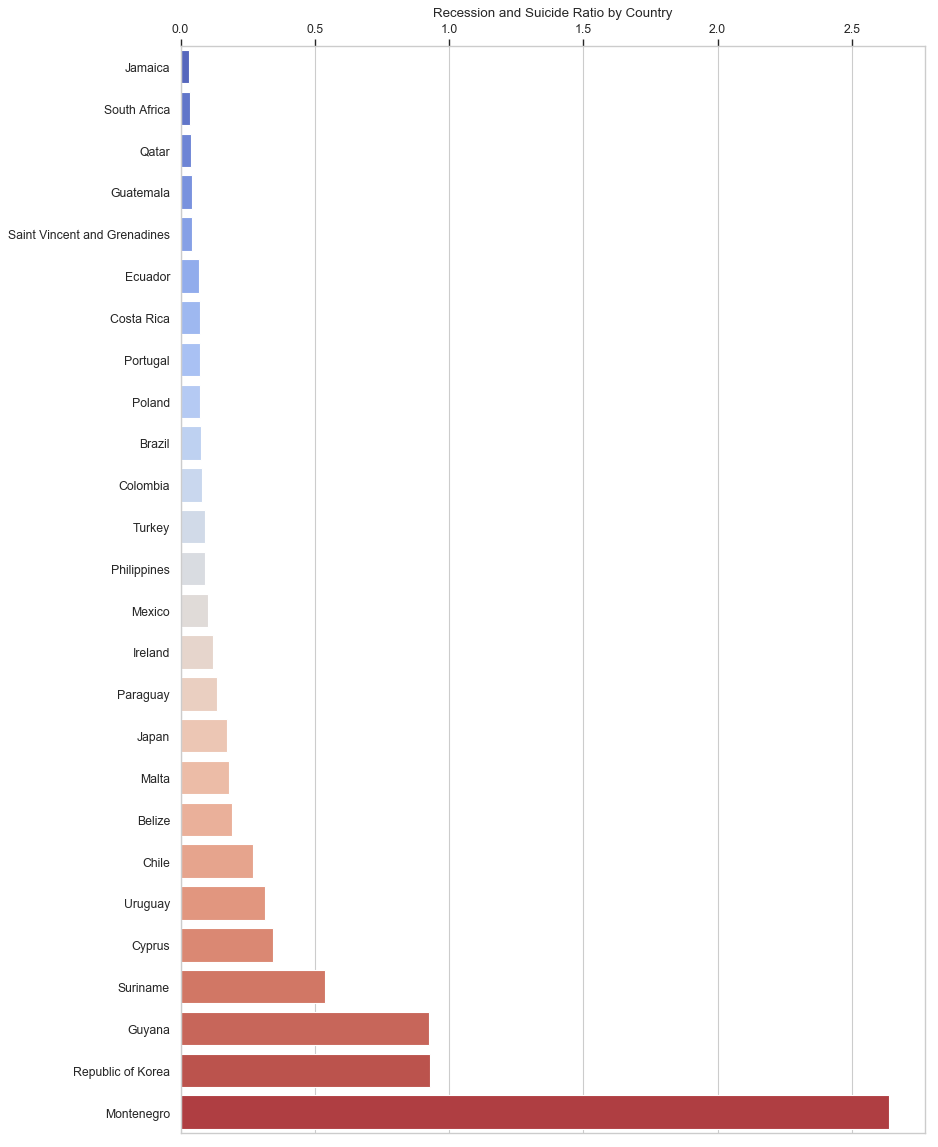

In [47]:
fig, ax = plt.subplots(figsize=(12,18), dpi=80);
sb.barplot(data=df_recession_trends, y='Country', x='factor',
            dodge=False, palette='coolwarm', ci=None
            ).set(ylabel='');

ax.set_title('Recession and Suicide Ratio by Country')
ax.xaxis.tick_top();
ax.xaxis.label.set_visible(False);

In [48]:
#only 26 countries showed significant positive trend in suicide rate during the recession

mean_y = recession_df.groupby('Country').apply(lambda x: x[['Year','suicides_no']].corr().iloc[0, 1])
print(mean_y.mean())

-0.08189336963452226


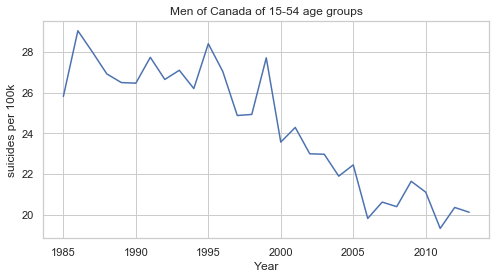

In [51]:


canada_age_df = train[(train.Sex>='male') & ((train.Age=='15-24') | (train.Age=='25-34') | (train.Age=='35-54'))][['Country','Year','Age','suicides_no','population']]
canada_age_df = canada_age_df[(canada_age_df.Country=='Canada')]
canada_age_df = pd.DataFrame({"suicides_per_100k": canada_age_df.groupby(['Country','Year'])['suicides_no'].sum() 
                                          / canada_age_df.groupby(['Country','Year'])['population'].sum() * 100000,
                                     
                                })
canada_age_df = canada_age_df.reset_index().sort_values('suicides_per_100k', ascending=False)

plt.figure(figsize=(8, 4))
g = sb.lineplot(x="Year", y="suicides_per_100k", markers=True, dashes=False, data=canada_age_df, ci=None);
g.set(title='Men of Canada of 15-54 age groups',ylabel='suicides per 100k');